# Verify the weight of V+ FFNN(can not show the power of quantum)

## Prepare environment and  define parameters 

In [1]:
is_colab = False
import sys
if is_colab:
    try:
        import torch  
        print('Module torch was installed')
    except ImportError:    
        print("Installinng torch 1.8.1")
        !pip install -q torch==1.8.1
    try:
        import torchvision  
        print('Module torchvision was installed')
    except ImportError:    
        print("Installinng torchvision 0.4.0")
        !pip install -q torchvision==0.4.0
    
    try:
        import qiskit  
        print('Module qiskit was installed')
    except ImportError:    
        print("Installinng qiskit 0.14.0")
        !pip install -q qiskit==0.14.0

    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VYR5kM8oCGaMXPIq0K1UY7u53a77vmHA' -O codes.tar.gz
    !tar zxvf /content/codes.tar.gz

    sys.path.append('/content/libs/')

import torch
import torchvision

import qiskit
from qiskit import  QuantumCircuit, ClassicalRegister
import numpy as np
import functools

In [2]:
sys.path.append('../')
from src.qfnn.qf_fb.q_output import fire_ibmq,analyze,add_measure
from src.qfnn.qf_circ.f_lyr_circ import F_LYR_Circ
from src.qfnn.qf_circ.v_lyr_circ import V_LYR_Circ
from src.qfnn.qf_net.utils import binarize
from src.qfnn.qf_fb.q_input import UMatrixCircuit
from src.qfnn.qf_fb.c_input import load_data,to_quantum_matrix

print = functools.partial(print, flush=True)



################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
ori_img_size = 28
img_size = 4
num_workers = 0 # number of subprocesses to use for data loading
batch_size = 1# how many samples per batch to load
inference_batch_size = 1
isppd = False #is prepared data

################ Zhirui on 12-30-2020 ################
# path
######################################################
if is_colab:
    data_path = '/content/data' #mnist  path
    resume_path = '/content/libs/best_model/v_u.tar' #model path
else:
    data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data' #mnist  path
    resume_path = '/home/hzr/Software/quantum/qc_mnist/model/exe_mnist.py_2021_08_08-16_00_34/model_best.tar' #model path

## Load data

In [3]:
train_loader, test_loader = load_data(interest_num,data_path,isppd,img_size,batch_size,inference_batch_size,False)


for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    break

Batch Id: 0, Target: tensor([0])


## Inference

In [4]:
################ hzr on 12-30-2020 ################
# Get the parameters of the trained model
######################################################

# Model initialization
checkpoint = torch.load(resume_path, map_location='cpu')
print(checkpoint['state_dict']['fc0.theta'])
print(checkpoint['state_dict']['fc1.weight'])
theta = checkpoint['state_dict']['fc0.theta']
weight = checkpoint['state_dict']['fc1.weight']


tensor([-5.3796,  0.7002,  1.8451, -5.7278,  0.1500, -0.3549,  3.5649,  5.7828],
       dtype=torch.float64)
tensor([[-37.2579,  37.5035, -36.9454,  36.6320, -37.5422, -30.4944,  45.8007,
           9.1910,  39.2518,  36.8431,  40.8417,  34.0796,  -7.6042, -39.2305,
          34.1263,  43.2855],
        [-35.8045, -12.2471, -31.9292, -22.6312,  19.5908, -40.1494,  35.5673,
          41.5370, -32.6166, -36.5595, -15.5469, -37.7452, -36.7410, -37.6752,
          38.4902,  39.5903]])


In [5]:
################ hzr on 12-30-2020 ################
# Generate the circuit of u-Matrix
######################################################

#init circuit
circuit = QuantumCircuit()
#define your input and repeat number
u_mat = UMatrixCircuit(4,2)
#add input qubit to your circuit if needed
inputs = u_mat.add_input_qubits(circuit)
#add u-matrix to your circuit
u_mat.forward(circuit,inputs,quantum_matrix)

In [6]:
################ hzr on 12-30-2020 ################
# Generate the circuit of v-layer
######################################################

#define your input and repeat number
vqc = V_LYR_Circ(4,2)
#add v-layer to your circuit
vqc.forward(circuit,inputs,'v10',np.array(theta))


z_count=  0
z_count=  1
z_count=  1
z_count=  2
z_count=  2
z_count=  2
z_count=  2
z_count=  3
z_count=  0
z_count=  1
z_count=  2
z_count=  2
z_count=  3
z_count=  3
z_count=  3
z_count=  4


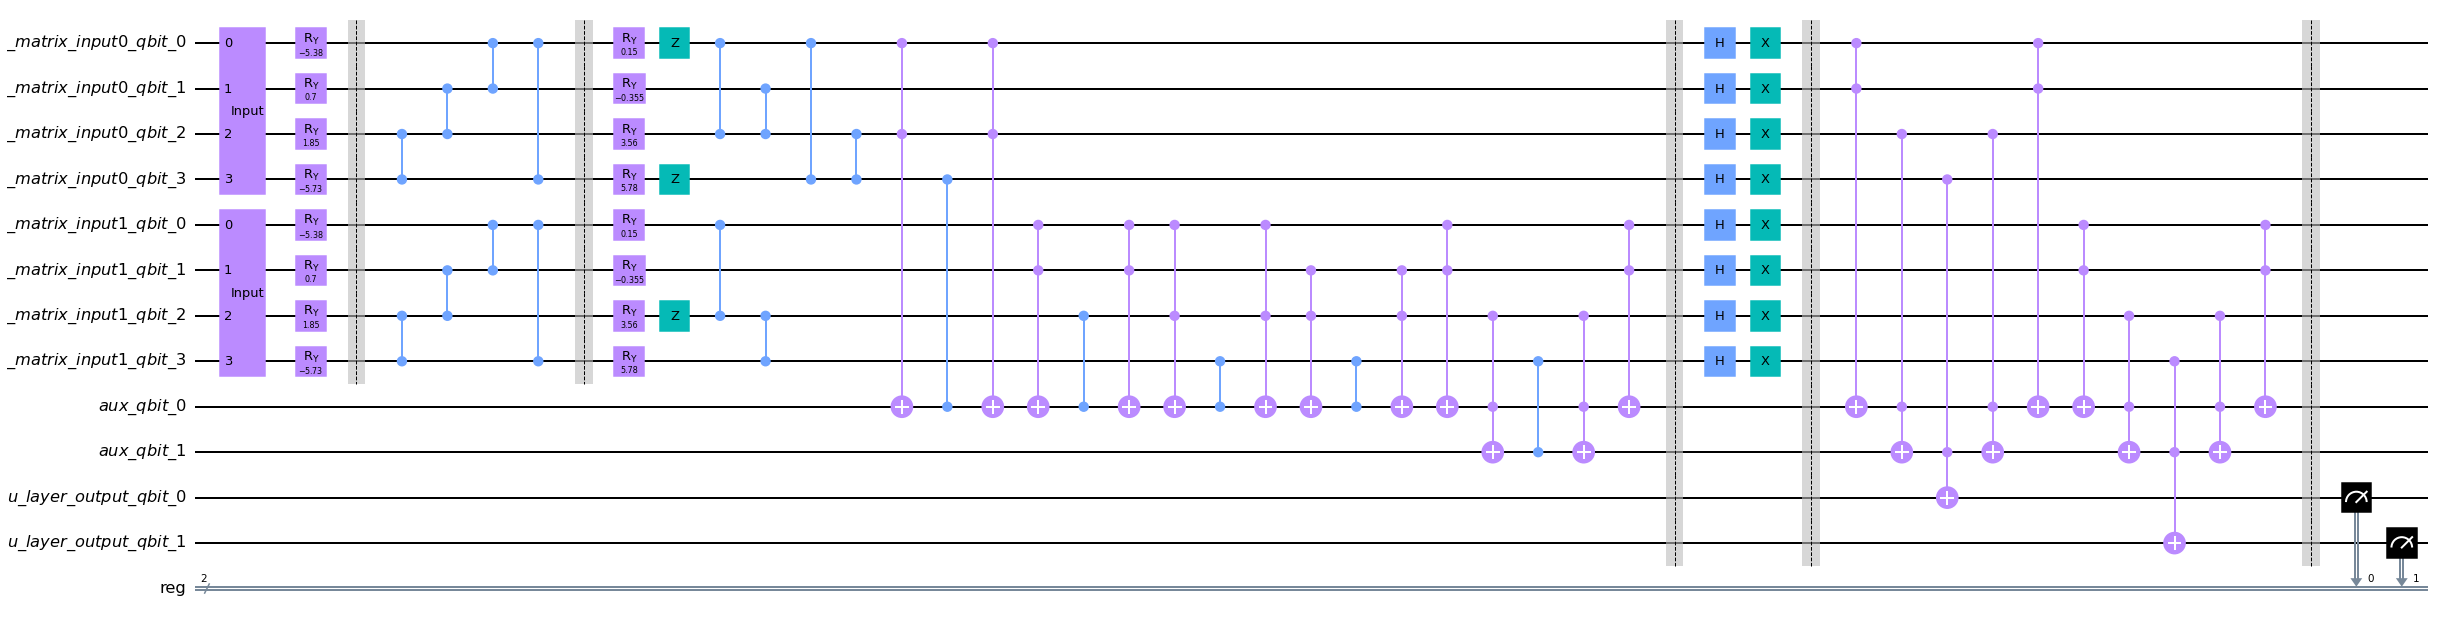

In [7]:
################ hzr on 12-30-2020 ################
# Generate the circuit of FFNN-layer
######################################################

#define your input and repeat number
ffnn_layer = F_LYR_Circ(4,2)

#add auxiliary qubit to your circuit if needed
aux =ffnn_layer.add_aux(circuit)

#add output qubit to your circuit if needed
ffnn_layer_out_qubits = ffnn_layer.add_out_qubits(circuit)

#add ulayer to your circuit
ffnn_layer.forward(circuit,binarize(weight),inputs,ffnn_layer_out_qubits,None,aux)


circuit.barrier()
#add measurement to your circuit if needed
add_measure(circuit,ffnn_layer_out_qubits,'reg')

#show your circuit
if is_colab:
    layout = 'text'
    fold = 300
else:
    layout = 'mpl'
    fold = 50

circuit.draw(layout,fold=fold)



### Non-Optimized Circuit v.s. Optimized Circuit

Let's test and compare!


In [8]:
################ Weiwen on 12-30-2020 ################
# Quantum simulation
######################################################


qc_shots=8192
opt_counts = fire_ibmq(circuit,qc_shots,True)
(opt_mycount,bits) = analyze(opt_counts)
opt_class_prob=[]
for b in range(bits):
    opt_class_prob.append(float(opt_mycount[b])/qc_shots)


print("Result of optimized QC:",opt_class_prob)
print("Prediction class: {}".format(opt_class_prob.index(max(opt_class_prob))))
print("Target class: {}".format(target[0]))
if opt_class_prob.index(max(opt_class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")
print("="*30)

Result of optimized QC: [0.445556640625, 0.2392578125]
Prediction class: 0
Target class: 0
Correct prediction
